# Import Packages and Setup Plotting

In [1]:
!pip install tensorboardX
!pip install torch
!pip install torchvision

In [1]:
import torch
torch.set_default_dtype(torch.float64) #keep more precision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import seaborn as sns
import os

%matplotlib inline
import matplotlib.pyplot as plt
import tensorboard
import tensorboardX
import torchvision
import random

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import brier_score_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import brier_score_loss
from numpy import genfromtxt

from torch.autograd import Variable
from torch.utils.data import Dataset, TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix
from tensorboardX import SummaryWriter
from numpy import arcsinh as arcsinh
from torchvision import models
from pathlib import Path
from tqdm import tqdm
print(torch.__version__)

from import_and_scale import *
from networks import *
from training import *
from onepixel_attack import *
from church_window import *
from training import *
from isomap_plot import *

1.4.0


In [2]:
torch.cuda.get_device_name(0)

'Tesla V100-SXM2-16GB'

In [3]:
#fix seed
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
random.seed(0)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.enabled=False
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(0)

dsets = {}
dset_loaders = {}

In [4]:
#plotting setup 
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'regular'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

plt.rcParams['font.family'] = [u'serif']
plt.rcParams['font.size'] = 20

sns.set()
#sns.set_style("dark")
sns.set_style("white")
sns.set_palette("muted")
sns.set_color_codes("muted")

# Import Data
## Y10 LSST mocks

In [7]:
# training and validation datasets

data_dir = './Data/'
x_file_train = 'images_Y10_train.npy'
y_file_train = 'labels_train.npy'
x_file_valid = 'images_Y10_valid.npy'
y_file_valid = 'labels_valid.npy'

x1 = array_to_tensor(os.path.join(data_dir, x_file_train))
y1 = array_to_tensor(os.path.join(data_dir, y_file_train))
x3 = array_to_tensor(os.path.join(data_dir, x_file_valid))
y3 = array_to_tensor(os.path.join(data_dir, y_file_valid))

# normalize images
update_sinh(x1)
update_sinh(x3)

# create dataloaders
dsets["train"] = TensorDataset(x1, y1)
dsets["valid"] = TensorDataset(x3, y3)

dset_loaders["train"] = DataLoader(dsets["train"], batch_size = 128, shuffle = True, num_workers = 0)
dset_loaders["valid"] = DataLoader(dsets["valid"], batch_size = 64, shuffle = True, num_workers = 0)

# delete what is not needed from memory 
del x1, y1, x3, y3

In [2]:
# test set

data_dir = './Data/'
x_file_test = 'images_Y10_test.npy'
y_file_test = 'labels_test.npy'

x2 = array_to_tensor(os.path.join(data_dir, x_file_test))
y2 = array_to_tensor(os.path.join(data_dir, y_file_test))
update_sinh(x2)

dsets["test"] = TensorDataset(x2, y2)
dset_loaders["test"] = DataLoader(dsets["test"], batch_size = 64, shuffle = False, num_workers = 0)

#do not delete, since it will be needed for some functions later
#del x2, y2 

## Y1 noisy LSST mocks

In [ ]:
# training and validation datasets

data_dir = './Data/'
x_file_train = 'images_Y1_train.npy'
y_file_train = 'labels_train.npy'
x_file_valid = 'images_Y1_valid.npy'
y_file_valid = 'labels_valid.npy'

noisy_x1 = array_to_tensor(os.path.join(data_dir, x_file_train))
noisy_y1 = array_to_tensor(os.path.join(data_dir, y_file_train))
noisy_x3 = array_to_tensor(os.path.join(data_dir, x_file_valid))
noisy_y3 = array_to_tensor(os.path.join(data_dir, y_file_valid))

# normalize images
update_sinh(noisy_x1)
update_sinh(noisy_x3)

# create dataloaders
dsets["noisy_train"] = TensorDataset(noisy_x1, noisy_y1)
dsets["noisy_valid"] = TensorDataset(noisy_x3, noisy_y3)

dset_loaders["train_noisy"] = DataLoader(dsets["noisy_train"], batch_size = 128, shuffle = True, num_workers = 0)
dset_loaders["valid_noisy"] = DataLoader(dsets["noisy_valid"], batch_size = 64, shuffle = True, num_workers = 0)

del noisy_x1, noisy_y1, noisy_x3, noisy_y3

In [3]:
# test set

data_dir = './Data/'
x_file_test_n = 'images_Y1_test.npy'
y_file_test_n = 'labels_test.npy'

noisy_x2 = array_to_tensor(os.path.join(data_dir, x_file_test_n))
noisy_y2 = array_to_tensor(os.path.join(data_dir, y_file_test_n))
update_sinh(noisy_x2)

dsets["test_noisy"] = TensorDataset(noisy_x2, noisy_y2)
dset_loaders["test_noisy"] = DataLoader(dsets["test_noisy"], batch_size = 64, shuffle = False, num_workers = 0)

# #do not delete, since it will be needed for some functions later
# #del noisy_x2, noisy_y2

## Small 30-image test sub-samle for church window plots and adversarial attacks

In [4]:
# FOR SMALL 30
data_dir = './Data/'

regular30 = 'regular_images_30.npy'
noise30 = 'noisy_images_30.npy'
label30 = 'labels_30.npy'

reg30 = array_to_tensor(os.path.join(data_dir, regular30))
noi30 = array_to_tensor(os.path.join(data_dir, noise30))
lab30 = array_to_tensor(os.path.join(data_dir, label30))

update_sinh(noi30)
update_sinh(reg30)

# create dataloaders
dsets["small_reg"] = TensorDataset(reg30, lab30)
dsets["small_noise"] = TensorDataset(noi30, lab30)

dset_loaders["small_reg"] = DataLoader(dsets["small_reg"], batch_size = 1, shuffle = False, num_workers = 0)
dset_loaders["small_noise"] = DataLoader(dsets["small_noise"], batch_size = 1, shuffle = False, num_workers = 0)

# Train and Evaluate

In [5]:
# calculate class weights for weighted cross-entropy loss
spiral_count = np.count_nonzero(dsets["train"][:,0][1])
elliptical_count = np.count_nonzero(dsets["train"][:,1][1])
merger_count = np.count_nonzero(dsets["train"][:,2][1])
nSamples = [spiral_count, elliptical_count, merger_count]

weights = [sum(nSamples)/(3.0 * x) for x in nSamples]

In [12]:
# load tensorboard to track progress

%reload_ext tensorboard
%tensorboard --logdir './output/'

In [6]:
## TRAIN ##
base_network = ConvNet()
#base_network = ResNetFc()

epochs = 100
early_stop_patience = 10
output_path = './output/CN'

# train 
train(base_network, dset_loaders, weights, epochs, early_stop_patience, output_path, use_gpu= True)

# also save CPU version of the trained model
base_network.to(torch.device('cpu'))
torch.save(base_network.state_dict(), "./output/CN/best_model_CPU.pth.tar")

In [ ]:
## TRAIN WITH DOMAIN ADAPTATION ##
base_network = ConvNet()
#base_network = ResNetFc()

epochs = 100
early_stop_patience = 10
output_path = './output/CN_DA'

# train with domain adaptation
train_da(base_network, dset_loaders, weights, epochs, early_stop_patience, output_path, use_gpu= True)

# also save CPU version of the trained model
base_network.to(torch.device('cpu'))
torch.save(base_network.state_dict(), "./output/CN_DA/best_model_CPU.pth.tar")

## Load Trained Weights

In [8]:
# ConvNet
ckpt = torch.load('outputs/CN/best_model.pth.tar', map_location=torch.device('cuda')) 
#ckpt = torch.load('outputs/CN_DA/best_model.pth.tar', map_location=torch.device('cuda')) # for domain adaptation model

base_network = ConvNet()

print('recorded best training accuracy: {:0.4f} at epoch {:0.1f}'.format(ckpt["train accuracy"], ckpt["epoch"]))
print('recorded best validation accuracy: {:04f} at epoch {:0.1f}'.format(ckpt["valid accuracy"], ckpt["epoch"]))

copy = ckpt['base_network']
base_network.load_state_dict(copy)
base_network.eval()

# building corresponding embedding net which only has the final dense layers (needed for church window plots)
remove = ['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias',
           'batchn1.weight', 'batchn1.bias', 'batchn1.running_mean', 'batchn1.running_var', 
           'batchn1.num_batches_tracked', 'batchn2.weight', 'batchn2.bias', 'batchn2.running_mean', 
           'batchn2.running_var', 'batchn2.num_batches_tracked', 'batchn3.weight', 'batchn3.bias', 
           'batchn3.running_mean', 'batchn3.running_var', 'batchn3.num_batches_tracked', 'bottleneck.weight', 'bottleneck.bias']

for key in remove:
  copy.pop(key)

embedding_network = EndCN()
embedding_network.load_state_dict(copy)
embedding_network.eval()

# move to GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    base_network = base_network.cuda()
    embedding_network = embedding_network.cuda()

In [9]:
#test trained model on Y10 and Y1 data as well as 30-image sub-samples

test_acc, CM = classification_test(dset_loaders, "test", base_network, gpu = True, verbose = True, save_where = 'outputs/CN') #or save to 'outputs/CN_DA' for domain adaptation model
print("Y10 test set:", test_acc)
print(CM)

test_acc, CM = classification_test(dset_loaders, "test_noisy", base_network, gpu = True, verbose = True, save_where = 'outputs/CN')
print("Y1 test set:", test_acc)
print(CM)

test_acc, CM = classification_test(dset_loaders, "small_reg", base_network, gpu = True, verbose = True, save_where = 'outputs/CN')
print("Y10 30-image test set:", test_acc)
print(CM)

test_acc, CM = classification_test(dset_loaders, "small_noise", base_network, gpu = True, verbose = True, save_where = 'outputs/CN')
print("Y1 30-image test set:", test_acc)
print(CM)

In [10]:
# RESNET

#this is the wrong model but
ckpt = torch.load('./outputs/RN/best_model.pth.tar', map_location=torch.device('cuda'))
#ckpt = torch.load('./outputs/RN_DA/best_model.pth.tar', map_location=torch.device('cuda')) # for domain adaptation model
base_network = ResNetFc() 

print('recorded best training accuracy: {:0.4f} at epoch {:0.1f}'.format(ckpt["train accuracy"], ckpt["epoch"]))
print('recorded best validation accuracy: {:04f} at epoch {:0.1f}'.format(ckpt["valid accuracy"], ckpt["epoch"]))

copy = ckpt['base_network']
base_network.load_state_dict(copy) 
base_network.eval()

# building corresponding embedding net which only has the final dense layers (needed for church window plots)
remove = list(copy.keys())[:-2]

for key in remove:
  copy.pop(key)

embedding_network = EndResNetFc()
embedding_network.load_state_dict(copy)
embedding_network.eval()

# move to GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    base_network = base_network.cuda()
    embedding_network = embedding_network.cuda()

In [ ]:
#test trained model on Y10 and Y1 data as well as 30-image sub-samples

test_acc, CM = classification_test(dset_loaders, "test", base_network, gpu = True, verbose = True, save_where = 'outputs/RN') #or save to 'outputs/RN_DA' for domain adaptation model
print("Y10 test set:", test_acc)
print(CM)

test_acc, CM = classification_test(dset_loaders, "test_noisy", base_network, gpu = True, verbose = True, save_where = 'outputs/RN')
print("Y1 test set:", test_acc)
print(CM)

test_acc, CM = classification_test(dset_loaders, "small_reg", base_network, gpu = True, verbose = True, save_where = 'outputs/RN')
print("Y10 30-image test set:", test_acc)
print(CM)

test_acc, CM = classification_test(dset_loaders, "small_noise", base_network, gpu = True, verbose = True, save_where = 'outputs/RN')
print("Y1 30-image test set:", test_acc)
print(CM)

# One-Pixel Attack and Church Window Plots
[See more here](https://github.com/nitarshan/one-pixel-attack/blob/master/One%20Pixel%20Attack%20for%20Fooling%20Deep%20Neural%20Networks.ipynb)



Device: cuda
Ground truth:  tensor(0, device='cuda:0')
Predicted class:  tensor(0, device='cuda:0')
Noisy predicted class:  tensor(0, device='cuda:0')
Flip to:  1
Target Probability [Iteration 0]: 0.020670934500087664
Target Probability [Iteration 10]: 0.05816983753960463
Target Probability [Iteration 20]: 0.12350363514390057
Target Probability [Iteration 30]: 0.12350363514390057
Target Probability [Iteration 40]: 0.13491822917301388
Didn't flip within chosen max iterations.
Flip to:  2
Target Probability [Iteration 0]: 0.1191944376553061
Target Probability [Iteration 10]: 0.20000799255833193
Target Probability [Iteration 20]: 0.395697088397507
Worked at iteration :  26


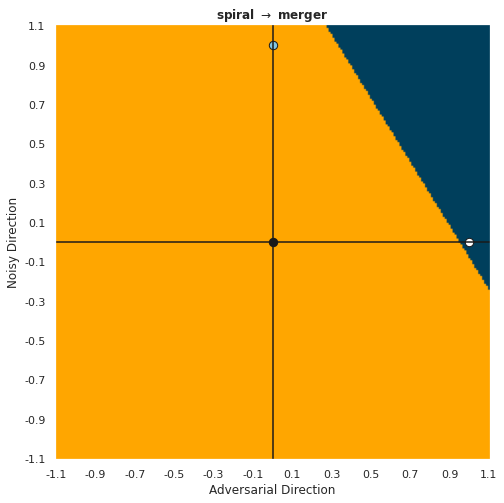

In [34]:
# attack one of the images in 30-image subsample and create a church window plot
# load base_network and embedding_network that you want before

which = 1
img, img_n, img_p = church_window(True, base_network, embedding_network, reg30[which].unsqueeze(0).cuda(), noi30[which].unsqueeze(0).cuda(), torch.argmax(lab30[which]).cuda(), iters = 50, save = False, name = which)

Device: cuda
Ground truth:  tensor(1, device='cuda:0')
Predicted class:  tensor(1, device='cuda:0')
Noisy predicted class:  tensor(0, device='cuda:0')
Flip to:  0
Worked at iteration :  1
Device: cuda
Ground truth:  tensor(1, device='cuda:0')
Predicted class:  tensor(1, device='cuda:0')
Noisy predicted class:  tensor(0, device='cuda:0')
Flip to:  0
Worked at iteration :  1
Device: cuda
Ground truth:  tensor(1, device='cuda:0')
Predicted class:  tensor(1, device='cuda:0')
Noisy predicted class:  tensor(2, device='cuda:0')
Flip to:  0
Target Probability [Iteration 0]: 0.03022078777656783
Target Probability [Iteration 10]: 0.03022078777656783
Target Probability [Iteration 20]: 0.03022078777656783
Target Probability [Iteration 30]: 0.21753707177360915
Target Probability [Iteration 40]: 0.23703546782976684
Target Probability [Iteration 50]: 0.3018473637750125
Target Probability [Iteration 60]: 0.3117360386488705
Target Probability [Iteration 70]: 0.33279533731893585
Didn't flip within chose

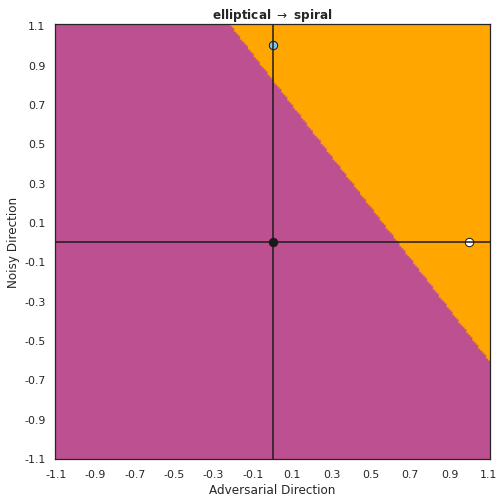

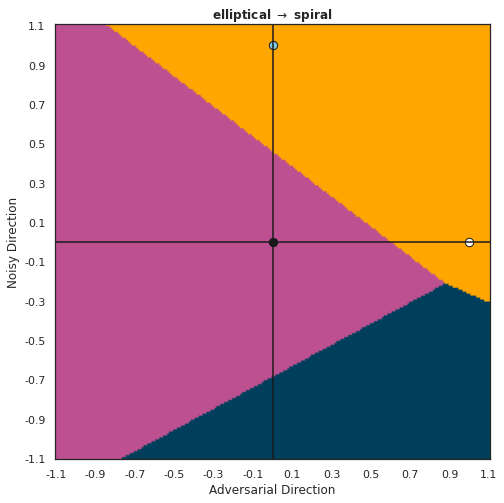

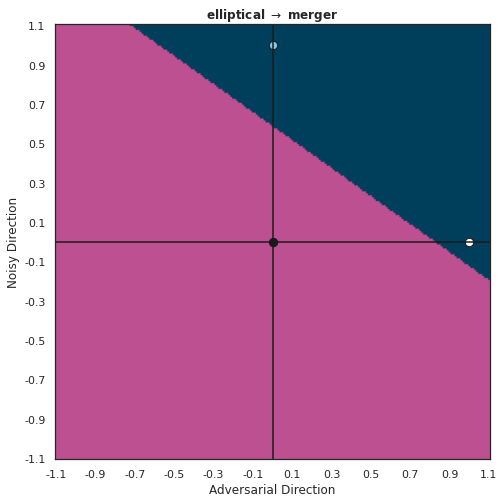

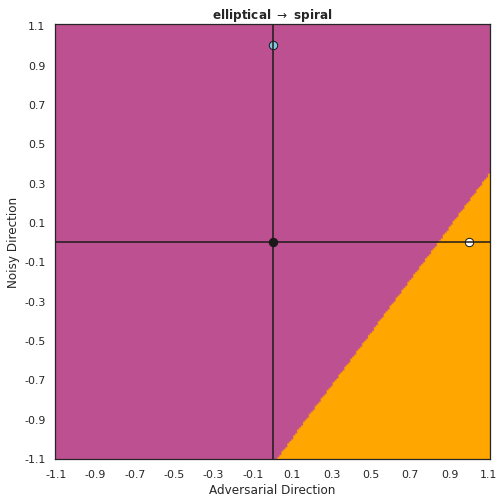

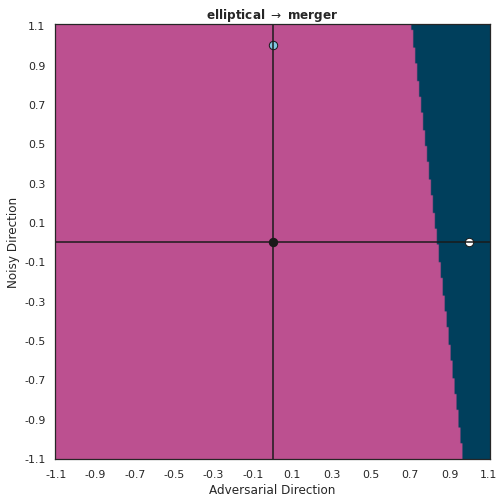

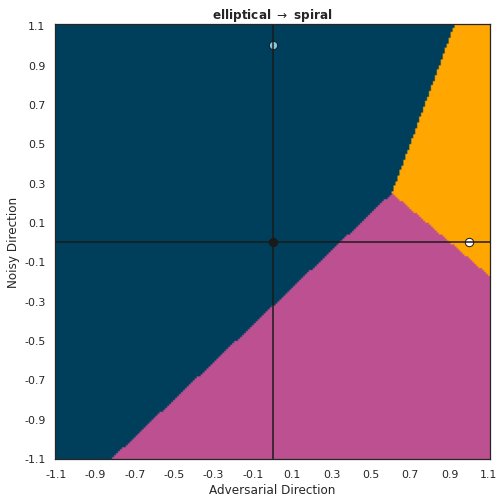

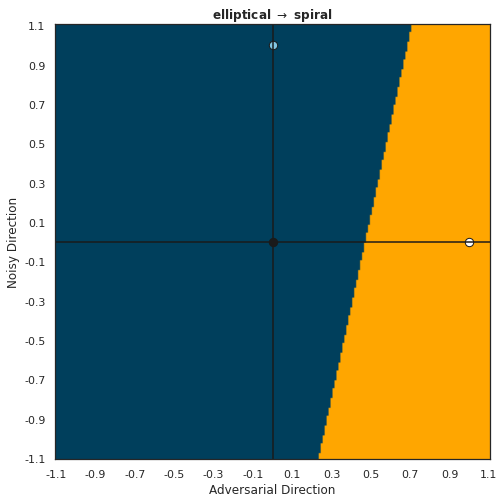

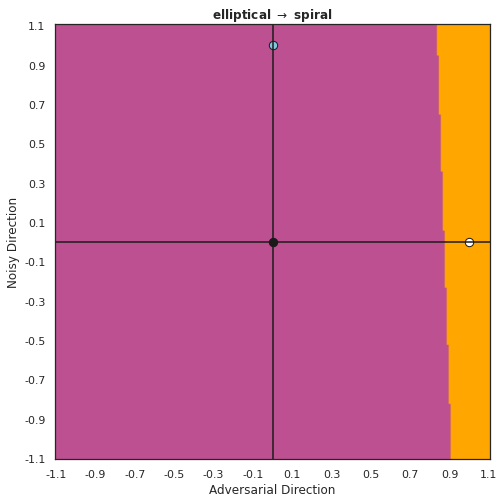

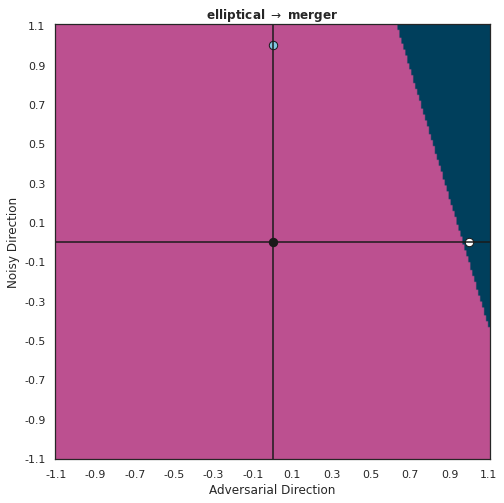

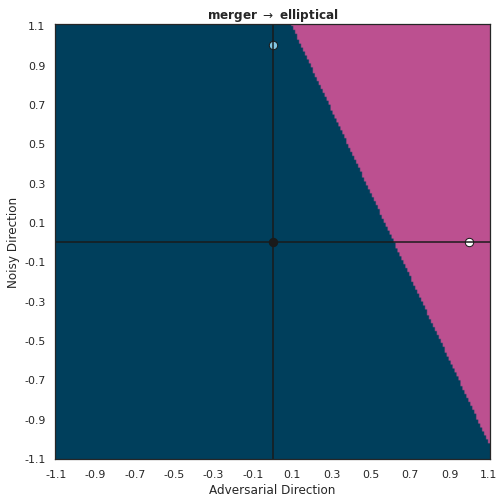

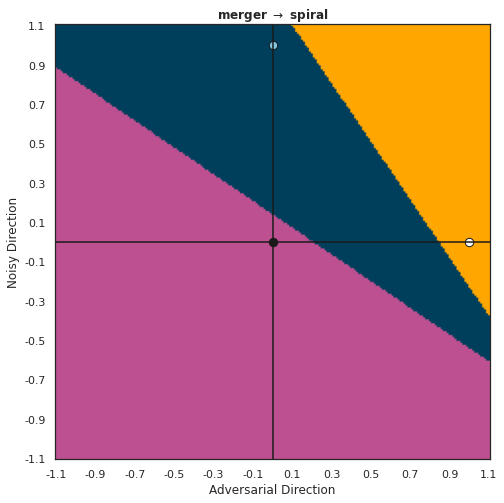

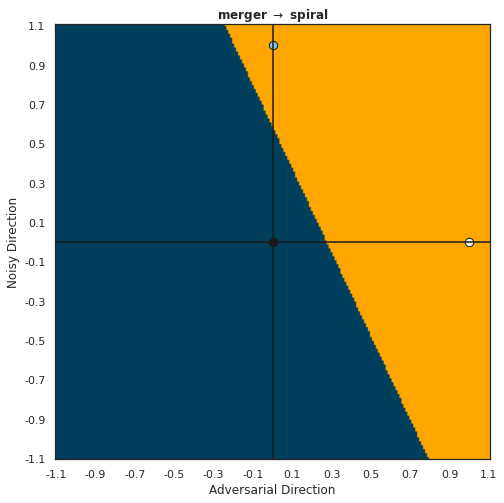

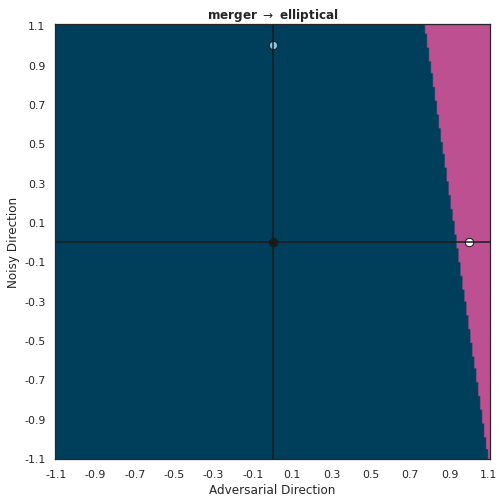

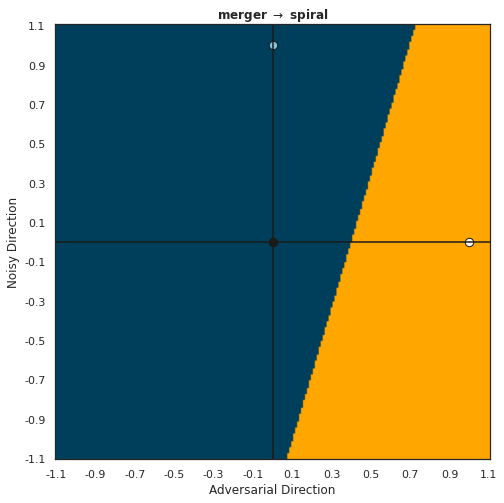

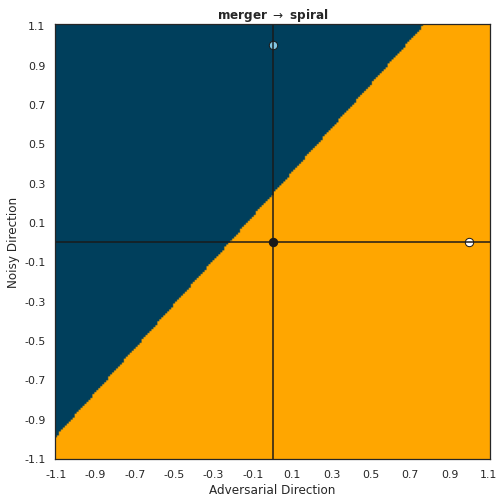

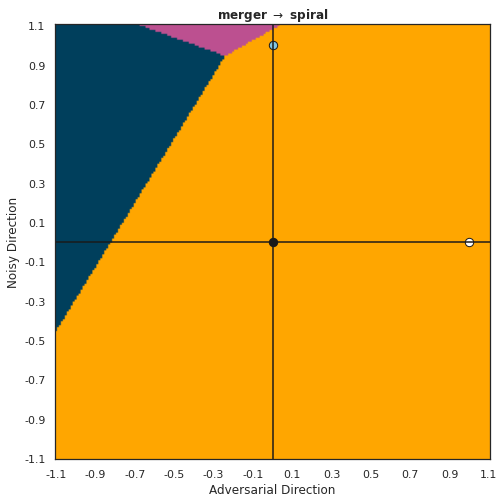

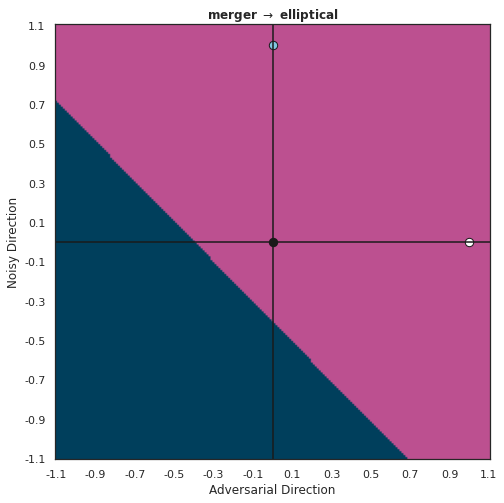

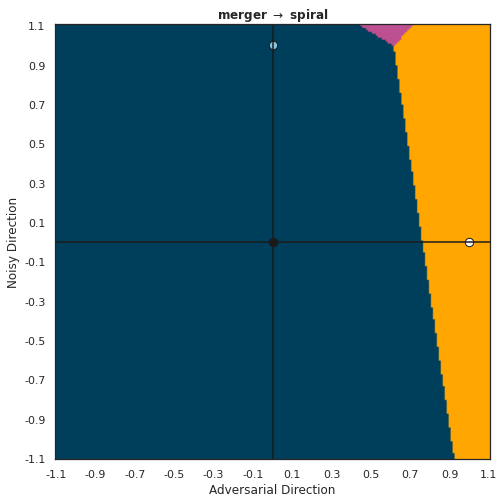

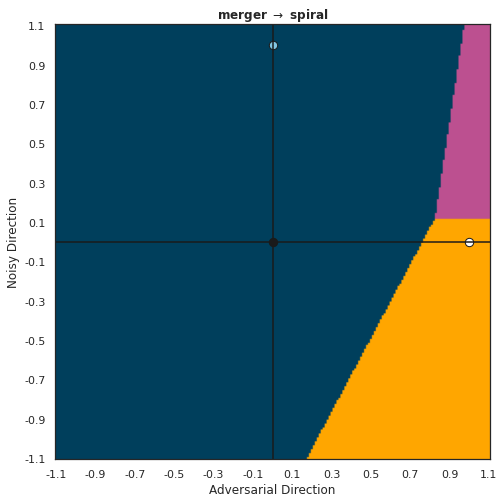

In [62]:
#or for a list of images:

#note: loop will break if image cannot be fliped to any of the classes, so you have to rerun this function for images after the one that failed
embed = []
noise = []
perturb = [] #comment out if reruning after the initial loop breaks

for i in range(0,30): # change range if reruning loop after it breaks
    which = i
    emb, nois, pert = church_window(True, base_network, embedding_network, reg30[which].unsqueeze(0).cuda(), noi30[which].unsqueeze(0).cuda(), torch.argmax(lab30[which]).cuda(), iters = 80, save = True, name = i)
    embed.append(emb)
    noise.append(nois)
    perturb.append(pert)

In [64]:
#save embeddings for 30-image triplet (we will need them for isomaps later)
torch.save(embed, 'embeddings/embedd_reg_RN.pt')
torch.save(noise, 'embeddings/embedd_noi_RN.pt')
torch.save(perturb, 'embeddings/embedd_pert_RN.pt')

# Isomaps

In [22]:
# load ambedings for 30-image subsamples
reg_embedding = torch.load('embeddings/embedd_reg_RN.pt')
nois_embedding = torch.load('embeddings/embedd_noi_RN.pt')
pert_embedding = torch.load('embeddings/embedd_pert_RN.pt')
reg_embedding = torch.stack(reg_embedding)
nois_embedding = torch.stack(nois_embedding)
pert_embedding = torch.stack(pert_embedding)

In [12]:
# plot 2D or 3D isomp and save
isomap_plot(embedding_network, reg_embedding[5:7], nois_embedding[5:7], pert_embedding[5:7], base_network, x2, noisy_x2, num=200, three_dim=False, save=True, where='isomap_RN')

In [11]:
# create and save rotating 3D isomap video (rotation can be horizontal or vertical)
ani = isomap_video(embedding_network, reg_embedding[5:7], nois_embedding[5:7], pert_embedding[5:7], base_network, x2, noisy_x2, num=50, vert=False, save=True, where='video_new/RN')

In [12]:
# preview the video here
plt.rcParams['animation.html'] = 'html5'
ani

# Euclidiean distances in the latent space as a measure of network robustness

In [1]:
# load embeddings for the model you are interested in
dist_metric(reg_embedding, nois_embedding, pert_embedding, pnorm = 2.0)

## Classification metrics

In [113]:
# load csv files with test set outputs for Y10 mocks
prob_Y10 = genfromtxt('outputs/RN/model_predictions_test.csv', delimiter=',') # or change path for other models
sp_prob_Y10 = prob_Y10[1:,1]
el_prob_Y10  = prob_Y10[1:,2]
merg_prob_Y10  = prob_Y10[1:,3]

results_Y10 = genfromtxt('outputs/RN/model_results_test.csv', delimiter=',')
pred_Y10 = results_Y10[1:,1]
y_Y10 = results_Y10[1:,2]


# load csv files with test set outputs for Y1 mocks
prob_Y1 = genfromtxt('outputs/RN/model_predictions_test_noisy.csv', delimiter=',')
sp_prob_Y1 = prob_Y1[1:,1]
el_prob_Y1  = prob_Y1[1:,2]
merg_prob_Y1  = prob_Y1[1:,3]

results_Y1 = genfromtxt('outputs/RN/model_results_test_noisy.csv', delimiter=',')
pred_Y1 = results_Y1[1:,1]
y_Y1 = results_Y1[1:,2]

In [2]:
#accuracy
acc_Y10 = accuracy_score(y_Y10, pred_Y10)
acc_Y1 = accuracy_score(y_Y1, pred_Y1)
acc = [acc_Y10, acc_Y1]
print('Accuracy source:', acc)


#precision
prec_Y10 = precision_score(y_Y10, pred_Y10, average='weighted')
prec_Y1 = precision_score(y_Y1, pred_Y1, average='weighted')
prec = [prec_Y10, prec_Y1]
print('Precision source:', prec)


#recall
recall_Y10 = recall_score(y_Y10, pred_Y10, average='weighted')
recall_Y1 = recall_score(y_Y1, pred_Y1, average='weighted')
recall = [recall_Y10, recall_Y1]
print('Recall source:', recall)


#F1
f1_Y10 = f1_score(y_Y10, pred_Y10, average='weighted')
f1_Y1 = f1_score(y_Y1, pred_Y1, average='weighted')
f1 = [f1_Y10, f1_Y1]
print('F1 source:', f1)